# TF-Slim 2.0 Walkthrough

This notebook will walk you through the basics of using TF-Slim to create, train and evaluate neural networks on various tasks. It assumes a basic knowledge of neural networks. 

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check that TF version is up to date
ver = tf.__version__
# e.g., ver = "0.9.0" or "0.10.0rc0"
ver_parts = ver.split(".")
if (int(ver_parts[0]) > 0) or (int(ver_parts[1]) >= 10):
    print 'You have TF version {}'.format(ver)
else:
    print 'Warning: You have TF version {}, you need version >= 0.10'.format(ver)

You have TF version 0.10.0rc0


## Creating your first neural network

Below we give some code to create a simple multilayer perceptron (MLP)  which can be used
for regression problems. The model has 2 hidden layers, with 100 and 50 units in them.
The output is a single node. 
When this function is called, it will create various nodes, and silently add them to whichever global TF graph is currently in scope. When a node which corresponds to a layer with adjustable parameters (eg., a fully connected layer) is created, additional parameter variable nodes are silently created, and added to the graph. (We will discuss how to train the parameters later.)
We use variable scope to put all the nodes under a common name,
so that the graph has some hierarchical structure.
This is useful when we want to visualize the TF graph in tensorboard, or if we want to query related
variables. The fully connected layers all use the same L2 weight decay and ReLu activations, as specified by arg_scope. (However, the final layer overrides these defaults, and uses an identity activation function.)
We also illustrate how to add a dropout layer after the first fully connected layer (FC1). Note that at test time, 
we do not drop out nodes, but instead use the average activations; hence we need to know whether the model is being
constructed for training or testing, since the computational graph will be different in the two cases
(although the variables, storing the model parameters, will be shared, since they have the same name/scope).

In [3]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
  """Creates the regression model.
  
  Args:
    input_node: A node that yields a `Tensor` of size [batch_size, dimensions].
    is_training: Whether or not we're currently training the model.
    scope: An optional variable_op scope for the model.
  
  Returns:
    output_node: 1-D `Tensor` of shape [batch_size] of responses.
    nodes: A dict of nodes representing the hidden layers.
  """
  with tf.variable_op_scope([input_node], scope):
    nodes = {}
    # Set the default weight _regularizer and acvitation for each fully_connected layer.
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_regularizer=slim.l2_regularizer(0.01)):
      
      # Creates a fully connected layer from the inputs with 10 hidden units.
      fc1_node = slim.fully_connected(inputs, 100, scope='fc1')
      nodes['fc1'] = fc1_node
        
      # Adds a dropout layer to prevent over-fitting.
      dropout_node = slim.dropout(fc1_node, 0.8, is_training=is_training)
      
      # Adds another fully connected layer with 5 hidden units.
      fc2_node = slim.fully_connected(dropout_node, 50, scope='fc2')
      nodes['fc2'] = fc2_node
      
      # Creates a fully-connected layer with a single hidden unit. Note that the
      # layer is made linear by setting activation_fn=None.
      prediction_node = slim.fully_connected(fc2_node, 1, activation_fn=None, scope='prediction')
      nodes['out'] = prediction_node

      return prediction_node, nodes

### Let's create the model and examine its structure.

We create a TF graph and call regression_model(), which adds nodes (tensors) to the graph. We then examine their shape, and print the names of all the model variables which have been implicitly created inside of each layer. We see that the names of the variables follow the scopes that we specified.

In [4]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
  # Dummy placeholders for arbitrary number of 1d inputs and outputs
  input_node = tf.placeholder(tf.float32, shape=(None, 1))
  output_node = tf.placeholder(tf.float32, shape=(None, 1))
  
  # Build model
  prediction_node, nodes = regression_model(input_node)
 
  # Print name and shape of each tensor.
  for k, v in nodes.iteritems():
    print k, 'shape = %s' % v.get_shape()
    
  # Print name of parameter nodes that have been added (values not yet initialized)
  print [v.name for v in slim.get_model_variables()]
    
  # Print the loss nodes that have been added by using arg_scope(weights_regularizer):
  for regularization_loss_node in tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES):
    print regularization_loss_node.op.name
  

fc1 shape = (?, 100)
fc2 shape = (?, 50)
out shape = (?, 1)
[u'deep_regression/fc1/weights:0', u'deep_regression/fc1/biases:0', u'deep_regression/fc2/weights:0', u'deep_regression/fc2/biases:0', u'deep_regression/prediction/weights:0', u'deep_regression/prediction/biases:0']
deep_regression/fc1/weights/Regularizer/l2_regularizer
deep_regression/fc2/weights/Regularizer/l2_regularizer
deep_regression/prediction/weights/Regularizer/l2_regularizer


### Let's create some 1d regression data .

We will train and test the model on some noisy observations of a nonlinear function.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


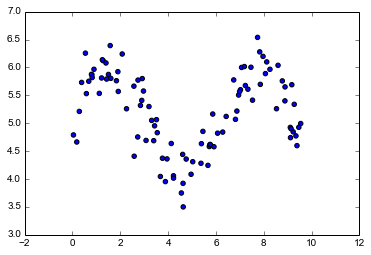

In [5]:
def produce_batch(batch_size, noise=0.3):
  xs = np.random.random(size=[batch_size, 1]) * 10
  ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
  return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(100)
x_test, y_test = produce_batch(100)
plt.scatter(x_train, y_train)

### Let's fit the model to the data

The user has to specify the loss function and the optimizer, and slim does the rest.
In particular,  the slim.learning.train function does the following:

- for each iteration, evaluate the train_op, which updates the parameters using the optimizer applied to the current minibatch.
- occasionally store the model checkpoint in the specified directory. This is useful in case your machine crashes  - then you can simply restart from the specified checkpoint.
- occasionally write summaries to ???. These can be examined in tensorboard.

In [6]:
# Everytime we run training, we need to store the model checkpoint in a new directory,
# in case anything has changed.
import time
ts = time.time()
ckpt_dir = '/tmp/model{}'.format(ts) # Place to store the checkpoint.
print('Saving to {}'.format(ckpt_dir))

Saving to /tmp/model1471737725.76


In [7]:
def convert_data_to_tensors(x, y):
  input_tensor = tf.constant(x)
  input_tensor.set_shape([None, 1])
  output_tensor = tf.constant(y)
  output_tensor.set_shape([None, 1])
  return input_tensor, output_tensor

In [8]:
# We make a new TF graph since we're calling regression_model again with different inputs.
# TODO: Reuse existing graph and just bind the existing input nodes to the data.

graph = tf.Graph()
with graph.as_default():
  input_node, output_node = convert_data_to_tensors(x_train, y_train)

  # Make the model.
  prediction_node, nodes = regression_model(input_node, is_training=True)
 
  # Add the loss function to the graph.
  loss_node = slim.losses.sum_of_squares(prediction_node, output_node)
  # The total loss is the uers's loss plus any regularization losses.
  total_loss_node = slim.losses.get_total_loss()

  # Create some summaries to visualize the training process:
  ## TODO: add summaries.py to 3p
  # slim.summaries.add_scalar_summary(total_loss, 'Total Loss', print_summary=True)
  
  # Specify the optimizer and create the train op:
  optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
  train_update_node = slim.learning.create_train_op(total_loss_node, optimizer)

  # Run the training inside a session.
  final_loss = slim.learning.train(
    train_update_node,
    logdir=ckpt_dir,
    number_of_steps=500,
    save_summaries_secs=1)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

('Finished training. Last batch loss:', 0.32073095)
Checkpoint saved in /tmp/model1471737725.76


### Training with multiple loss functions.

Sometimes we have multiple objectives we want to simultaneously optimize.
In slim, it is easy to add more losses, as we show below. (We do not optimize the total loss in this example,
but we show how to compute it.)

In [9]:
graph = tf.Graph()  # Make a new graph
with graph.as_default():
    input_node, output_node = convert_data_to_tensors(x_train, y_train)
    prediction_node, nodes = regression_model(input_node, is_training=True)

    # Add multiple loss nodes.
    sum_of_squares_loss_node = slim.losses.sum_of_squares(prediction_node, output_node)
    absolute_difference_loss_node = slim.losses.absolute_difference(prediction_node, output_node)

    # The following two ways to compute the total loss are equivalent
    regularization_loss_node = tf.add_n(slim.losses.get_regularization_losses())
    total_loss1_node = sum_of_squares_loss_node + absolute_difference_loss_node + regularization_loss_node

    # Regularization Loss is included in the total loss by default.
    # This is good for training, but not for testing.
    total_loss2_node = slim.losses.get_total_loss(add_regularization_losses=True)
    
    init_node = tf.initialize_all_variables()
    with tf.Session() as sess:
        sess.run(init_node) # Will randomize the parameters.
        total_loss1, total_loss2 = sess.run([total_loss1_node, total_loss2_node])
        print('Total Loss1: %f' % total_loss1)
        print('Total Loss2: %f' % total_loss2)


Total Loss1: 31.948940
Total Loss2: 31.948940


### Let's load the saved model and use it for prediction.

The predictive accuracy is not very good, because we only trained for 500 steps, to keep the demo fast.
Running for 5000 steps improves performance a lot.

Loss is 0.28607609868


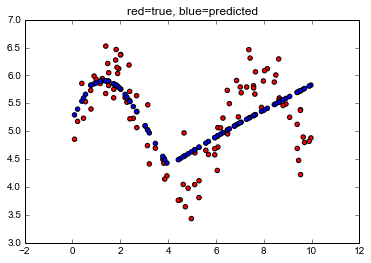

In [10]:
with tf.Graph().as_default():
    input_node, output_node = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    prediction_node, nodes = regression_model(input_node, is_training=False)
    # Add a loss node, for eval (not training) purposes.
    loss_node = slim.losses.sum_of_squares(prediction_node, output_node)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, true_outputs = sess.run([input_node, prediction_node, output_node])
        loss = sess.run(loss_node)

print("Loss is {}".format(loss)) # Loss is lower than when using random parameters
plt.scatter(inputs, true_outputs, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

### Let's examine the learned parameters.

In [11]:
with tf.Graph().as_default():
    input_node = tf.placeholder(tf.float32, shape=(None, 1))
    output_node = tf.placeholder(tf.float32, shape=(None, 1))
    prediction_node, nodes = regression_model(input_node, is_training=False)
  
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        model_variables = slim.get_model_variables()
        for v in model_variables:
            val = sess.run(v)
            print v.name, val.shape, val


deep_regression/fc1/weights:0 (1, 100) [[ -8.35221447e-03   1.14436932e-12   1.49819003e-12  -1.52324984e-14
   -4.12664823e-02  -3.03445826e-03  -2.37229485e-02   9.79221389e-02
   -4.76170145e-03  -4.82108118e-03  -1.08317584e-02   7.11413175e-02
   -1.85472574e-02   1.62936971e-01   1.19152248e-01  -2.87111616e-03
    1.21879607e-01   3.18809375e-02  -4.79533337e-02  -2.16852799e-02
    1.57013133e-01  -1.37560427e-12  -2.72389054e-02   7.51532391e-02
   -5.35035040e-03  -5.72365820e-01   6.51059346e-03   1.40266687e-01
   -2.58234981e-02  -1.89657379e-02   4.74746376e-02  -1.73595524e-03
   -4.05613594e-02  -9.93774161e-02   4.90166480e-03  -1.05544746e-01
   -5.64362388e-04   9.46550667e-02   1.39652863e-01  -9.09163952e-02
   -4.93474817e-03  -4.72848564e-02  -4.89405124e-03   3.09477970e-02
   -4.34413200e-11   1.47104328e-02   5.07518835e-02   1.67854965e-01
    8.40532482e-02   1.60468102e-01  -2.01878905e-01  -1.00495063e-01
    1.09624386e-01  -1.68555938e-02  -1.43390498e-0

### Let's compute various evaluation metrics on the test set.

In slim termiology, losses are optimized, but metrics (which may not be differentiable, e.g., precision and recall) are just measured.
As an illustration, the code below computes mean squared error and mean absolute error metrics on the test set.

Each metric declaration creates several local variables (which must be initialized via tf.initialize_local_variables()) and returns both a value_op and an update_op. When evaluated, the value_op returns the current value of the metric. The update_op loads a new batch of data, runs the model, obtains the predictions and accumulates the metric statistics appropriately before returning the current value of the metric. We store these value nodes and update nodes in 2 dictionaries.

After creating the metric nodes, we can pass them to slim.evaluation.evaluation, which repeatedly evaluates these nodes the specified number of times. (This allows us to compute the evaluation in a streaming fashion across minibatches, which is usefulf for large datasets.) Finally, we print the final value of each metric.


In [12]:
with tf.Graph().as_default():
    input_node, output_node = convert_data_to_tensors(x_test, y_test)
    prediction_node, nodes = regression_model(input_node, is_training=False)

    # Specify metrics to evaluate:
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
      'Mean Squared Error': slim.metrics.streaming_mean_squared_error(prediction_node, output_node),
      'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(prediction_node, output_node)
    })


    init_node = tf.group(
        tf.initialize_all_variables(),
        tf.initialize_local_variables())

    # Make a session which restores the old graph parameters, and then run eval.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        metric_values = slim.evaluation.evaluation(
            sess,
            num_evals=1, # Single pass over data
            init_op=init_node,
            eval_op=names_to_update_nodes.values(),
            final_op=names_to_value_nodes.values())

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.iteritems():
      print('%s: %f' % (key, value))

Mean Squared Error: 22.214493
Mean Absolute Error: 4.627326


# Slim datasets

Slim provides an easy way to handle datasets, without having to worry about which format
the data is stored in.

There are two main classes. Data Providers are python objects which can provide data tensors on demand.
They abstract away the details of how the data is stored, and allow data to be read in parallel
using queue runners, to support high throughput processing.

Data providers are constructed from slim Datasets, which can be created from data in various
file formats. The dataset has various forms of metadata, so it knows what kind of data is stored in the file.
Slim versions of various standard datasets, such as CIFAR, ImageNet, and COCO, can be found at XXX.
These have been converted from their original format into tfrecord.

Below we give an example of the CIFAR10 dataset, which has images and labels.  To save space, we just download the test file..

In [14]:
%load https://raw.githubusercontent.com/probml/pyprobml/master/tensorflow/cifar10_dataset.py


In [16]:
# Retrieve the data.
import six
import sys
from six.moves import urllib
url = 'https://github.com/probml/pyprobml/blob/master/tensorflow/cifar10_test.tfrecord'
filename = '/tmp/cifar10_test'
urllib.request.urlretrieve(url, filename)

('/tmp/cifar10_test', <httplib.HTTPMessage instance at 0x7f82006c5ab8>)

### Display the first image and its label.

In [ ]:
with tf.Graph().as_default(): 
    # The dataset must be constructed inside a tf graph.
    dataset = make_cifar_dataset('test', '/tmp')
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    print("This dataset contains data of type {}".format(data_provider.list_items()))
    
    image_node, label_node = data_provider.get(['image', 'label'])
    with tf.Session() as sess:    
        image, label = sess.run([image_node, label_node])
        with slim.queues.QueueRunners(sess):
            image, label = sess.run([image_node, label_node])
        
    print(label)
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

This dataset contains data of type ['image', 'label']


In [19]:
data_provider

# Convolutional neural nets (CNNs).

In this section, we show how to train an image classifier using a simple CNN.